In [1]:
import math

In [2]:
import pipe_pytools.polar_plot as pp
import pipe_pytools.tools as tl
import pipe_pytools.grid as gr

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
t,dt,cf,Re,Xmax,epsr,lx,Jm,lt,nsym,vel = tl.get_scp("tw-Re2500-Xmax5.scp")

In [5]:
x = gr.X(2**lx, Xmax)
r = gr.R(Jm, epsr)
th = gr.Th(2**lt, nsym)

In [6]:
Im = x.m
hx = x.h
yt = r.f
yt1 = r.f1
rt = r.n
rt1 = r.n1
Km = th.m
ht = th.h

In [7]:
def bc(vel):
    u,v,w = vel
        
    vel[:,:,:,0] = vel[:,:,:,-2]
    vel[:,:,:,-1] = vel[:,:,:,1]
    
    for i in range(0,Im+1):
        for j in range(1,Jm+1):
            u.T[i,j,0] = u.T[i,j,1]
            u.T[i,j,Km+1] = u.T[i,j,Km]
            
        for k in range(1,Km+1):
            u.T[i,Jm+1,k] = - u.T[i,Jm,k]
            
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            v.T[i,Jm,k] = 0.0
            
    for j in range(1,Jm+1):
        for i in range(1,Im+1):
            v.T[i,j,0] = v.T[i,j,1]
            v.T[i,j,Km+1] = v.T[i,j,Km]
            
    for j in range(1,Jm+1):
        for i in range(0,Im+2):
            w.T[i,j,0] = 0.0
            w.T[i,j,Km] = 0.0
            
    for k in range(0,Km+1):
        for i in range(1,Im+1):
            w.T[i,Jm+1,k] = - w.T[i,Jm,k] * yt[Jm] / yt[Jm+1]
            
    return vel

In [8]:
def rot(vel):
    bc(vel)
    u,v,w = vel
    
    om = np.zeros((3,Km+2,Jm+2,Im+2))
    ox,on,ot = om
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(0,Km+1):
                w0 = w.T[i,j,k]
                w1 = w.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i,j,k+1]
                ox.T[i,j,k] = ((yt[j+1]*w1 - yt[j]*w0) / rt1[j] - (v1 - v0) / ht) / rt[j]
                
        for j in range(0,1):
            for k in range(0,Km+1):
                ox.T[i,j,k] = 0.0
                
    for k in range(0,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j,k+1]
                w0 = w.T[i,j,k]
                w1 = w.T[i+1,j,k]
                on.T[i,j,k] = (u1 - u0) / (yt[j] * ht) - (w1 - w0) / hx
                
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(0,Im+1):
                u0 = u.T[i,j,k]
                u1 = u.T[i,j+1,k]
                v0 = v.T[i,j,k]
                v1 = v.T[i+1,j,k]
                ot.T[i,j,k] = (v1 - v0) / hx - (u1 - u0) / rt1[j]
    
    return om

In [9]:
def nonlin(vel,om):
    u,v,w = vel
    ox,on,ot = om
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i+1,j-1,k])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i+1,j,k])
                ot0 = rt[j-1] * rt1[j-1] * ot.T[i,j-1,k]
                ot1 = rt[j] * rt1[j] * ot.T[i,j,k]
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i+1,j,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i+1,j,k])
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = 0.5 * ((v0*ot0 + v1*ot1) / (yt[j] * yt1[j]) - (w0*or0 + w1*or1))
        
    for k in range(1,Km+1):
        for i in range(1,Im+1):
            for j in range(1,Jm):
                w0 = 0.5 * (w.T[i,j,k-1] + w.T[i,j+1,k-1])
                w1 = 0.5 * (w.T[i,j,k] + w.T[i,j+1,k])
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j+1,k])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j+1,k])
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = 0.5 * ((w0*ox0 + w1*ox1) - (u0*ot0 + u1*ot1))
        
            vt.T[i,Jm,k] = 0.0
            
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                u0 = 0.5 * (u.T[i-1,j,k] + u.T[i-1,j,k+1])
                u1 = 0.5 * (u.T[i,j,k] + u.T[i,j,k+1])
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                v0 = 0.5 * (v.T[i,j-1,k] + v.T[i,j-1,k+1])
                v1 = 0.5 * (v.T[i,j,k] + v.T[i,j,k+1])
                ox0 = rt[j-1] * rt1[j-1] * ox.T[i,j-1,k]
                ox1 = rt[j] * rt1[j] * ox.T[i,j,k]
                wt.T[i,j,k] = 0.5 * ((u0*or0 + u1*or1) - (v0*ox0 + v1*ox1) / (yt[j] * yt1[j]))
                
    return velt

In [10]:
def viscous(om,Re):
    ox,on,ot = om
    
    velt = np.zeros((3,Km+2,Jm+2,Im+2))
    ut,vt,wt = velt
    
    for i in range(1,Im+1):
        for j in range(1,Jm+1):
            for k in range(1,Km+1):
                ot0 = ot.T[i,j-1,k]
                ot1 = ot.T[i,j,k]
                or0 = on.T[i,j,k-1]
                or1 = on.T[i,j,k]
                ut.T[i,j,k] = - ((rt[j]*ot1 - rt[j-1]*ot0) / yt1[j] - (or1 - or0) / ht) / yt[j] / Re
        
    for k in range(1,Km+1):
        for j in range(1,Jm):
            for i in range(1,Im+1):
                ox0 = ox.T[i,j,k-1]
                ox1 = ox.T[i,j,k]
                ot0 = ot.T[i-1,j,k]
                ot1 = ot.T[i,j,k]
                vt.T[i,j,k] = - ((ox1 - ox0) / (rt[j] * ht) - (ot1 - ot0) / hx) / Re
        
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                ox0 = ox.T[i,j-1,k]
                ox1 = ox.T[i,j,k]
                or0 = on.T[i-1,j,k]
                or1 = on.T[i,j,k]
                wt.T[i,j,k] = - ((or1 - or0) / hx - (ox1 - ox0) / yt1[j]) / Re
        
    return velt

In [11]:
om = rot(vel)

In [12]:
nl = nonlin(vel,om)

In [13]:
vc = viscous(om,Re)

In [14]:
rot_nl = rot(nl)

In [15]:
rot_vc = rot(vc)

In [16]:
res = rot_nl + rot_vc
om[:,:,:,0] = om[:,:,:,-2]
om[:,:,:,-1] = om[:,:,:,1]
for i in range(1,Im+1):
    res[:,:,:,i] += cf * (om[:,:,:,i+1] - om[:,:,:,i-1]) / (2 * hx)

In [17]:
res[:,1:-1,1:-2,40].max()

0.0021420410431490233

In [18]:
rot_nl[:,1:-1,1:-1,1:-1].max()

0.53066414538698536

In [19]:
rot_vc[:,1:-1,1:-1,1:-1].max()

0.14159385716384285

In [12]:
VEL = np.zeros((3,Km+2,Jm+2,Im+2))
VEL.T[:] = vel.T[1:-1].mean(0)

In [13]:
OM = np.zeros((3,Km+2,Jm+2,Im+2))
OM.T[:] = om.T[1:-1].mean(0)

In [14]:
vel1 = vel - VEL
om1 = om - OM

In [15]:
d11 = rot(nonlin(vel1,om1))

In [17]:
def conv(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    cx = np.zeros_like(u)
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                cx[k,j,i] = - u[k,j,i] * (ox[k,j,i+1] - ox[k,j,i]) / hx \
                            - v[k,j,i] * (ox[k,j+1,i] - ox[k,j,i]) / yt1[j] \
                            - w[k,j,i] * (ox[k+1,j,i] - ox[k,j,i]) / (ht * yt[j])
                        
    return cx

In [37]:
def phi1(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    p1 = np.zeros_like(u)
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                p1[k,j,i] = ox[k,j,i] * (u[k,j,i+1] - u[k,j,i]) / hx
                    
    return p1

In [38]:
def phi2(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    p2 = np.zeros_like(u)
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                p2[k,j,i] = on[k,j,i] * (u[k,j+1,i] - u[k,j,i]) / yt1[j] + \
                            ot[k,j,i] * (u[k+1,j,i] - u[k,j,i]) / (yt[j] * ht)
                    
    return p2

In [64]:
c11 = conv(vel1,om1)

In [31]:
p1_11 = phi1(vel1,om1)

In [32]:
p2_11 = phi2(vel1,om1)

In [102]:
res = c11 + p1_11 + p2_11

In [104]:
np.abs((res - d11[0])[2:-2,2:-2,2:-2]).mean()

0.00031162815505524213

In [95]:
np.abs(d11[0,2:-2,2:-2,2:-2]).mean()

0.00080718434634564971

In [96]:
np.abs(c11[2:-2,2:-2,1:-1]).mean()

0.00074676787719794716

In [97]:
np.abs(p1_11[2:-2,2:-2,1:-1]).mean()

0.00047838497978093438

In [98]:
np.abs(p2_11[2:-2,2:-2,1:-1]).mean()

0.00029320612377017777

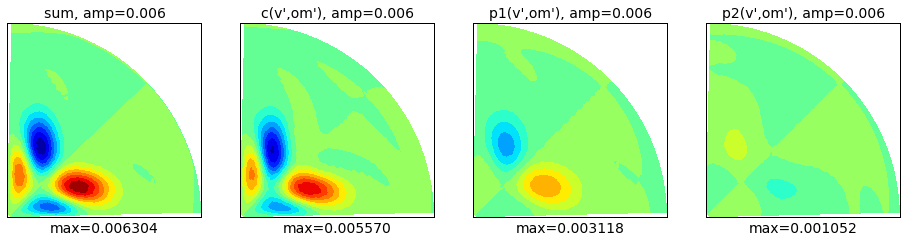

In [106]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], d11[0,1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))
plt.title("sum, amp=0.006", fontsize=14)
plt.xlabel("max=%f" % d11[0,2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,2)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,1:-1].mean(-1), (-0.006, 0.006))
plt.title("c(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,3)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], p1_11[1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))
plt.title("p1(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % p1_11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,4)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], p2_11[1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))
plt.title("p2(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % p2_11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

In [88]:
res = (nonlin(vel1 + om1, rot(vel1 + om1)) - nonlin(vel1, om1) - nonlin(om1, rot(om1)) - rot(nonlin(vel1,om1))) / 2

In [89]:
rrr = res[0] + p1_11 + p2_11

In [91]:
rrr[2:-2,2:-2,2:-2].max()

0.14870904660071507

In [92]:
res[0,2:-2,2:-2,2:-2].max()

0.14874737709512076

In [107]:
c11[2:16,2:-2,2:-2].mean()

0.00021789009271901919

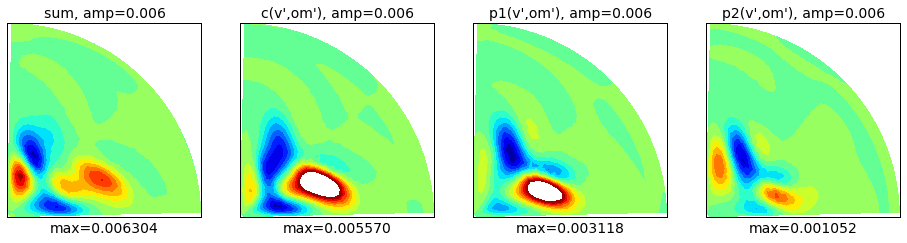

In [108]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,8], (-0.006,0.006))
plt.title("sum, amp=0.006", fontsize=14)
plt.xlabel("max=%f" % d11[0,2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,2)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,16], (-0.006, 0.006))
plt.title("c(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,3)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,24], (-0.006,0.006))
plt.title("p1(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % p1_11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,4)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,32], (-0.006,0.006))
plt.title("p2(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % p2_11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

## Составные части конвекции

In [51]:
def conv1(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    cx = np.zeros_like(u)
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                cx[k,j,i] = - (u[k,j,i+1] * ox[k,j,i+1] - u[k,j,i] * ox[k,j,i]) / hx 
                        
    return cx

In [70]:
def conv2(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    cx = np.zeros_like(u)
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                cx[k,j,i] = - (rt[j+1] * v[k,j+1,i] * ox[k,j+1,i] - rt[j] * v[k,j,i] * ox[k,j,i]) / (yt1[j] * yt[j])
                        
    return cx

In [71]:
def conv3(vel,om):
    u,v,w = vel
    ox,on,ot = om
    
    cx = np.zeros_like(u)
    
    for k in range(1,Km+1):
        for j in range(1,Jm+1):
            for i in range(1,Im+1):
                cx[k,j,i] = - (w[k+1,j,i] * ox[k+1,j,i] - w[k,j,i] * ox[k,j,i]) / (ht * yt[j])
                        
    return cx

In [72]:
c1 = conv1(vel1,om1)

In [73]:
c2 = conv2(vel1,om1)

In [74]:
c3 = conv3(vel1,om1)

In [77]:
(c11 - c1 - c2 - c3)[1:-1,1:-1,1:-1].max()

0.0085697645054882299

In [78]:
(c11)[1:-1,1:-1,1:-1].max()

0.02294391650061945

In [79]:
(c1)[1:-1,1:-1,1:-1].max()

0.025841885398375081

In [80]:
(c2)[1:-1,1:-1,1:-1].max()

0.018545487100431746

In [81]:
(c3)[1:-1,1:-1,1:-1].max()

0.019312098600804822

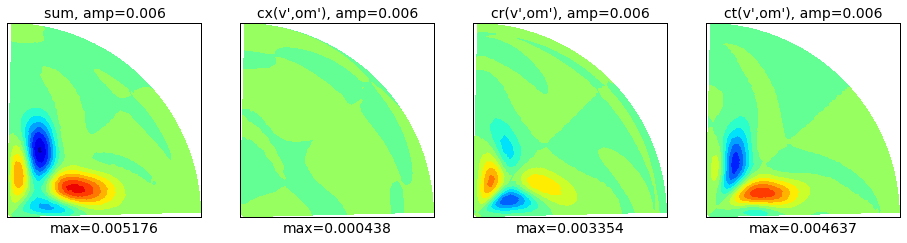

In [82]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))
plt.title("sum, amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,2)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c1[1:-1,1:-1,1:-1].mean(-1), (-0.006, 0.006))
plt.title("cx(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c1[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,3)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c2[1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))
plt.title("cr(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c2[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,4)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c3[1:-1,1:-1,1:-1].mean(-1), (-0.006,0.006))
plt.title("ct(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c3[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

In [36]:
vp = (vel1[1]**2)[:,:,1:-1].mean(-1)**0.5

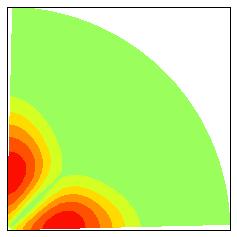

In [39]:
pp.polar_contourf(r.f[1:-1], th.f[1:-1], vp[1:-1,1:-1], (-0.01,0.01))

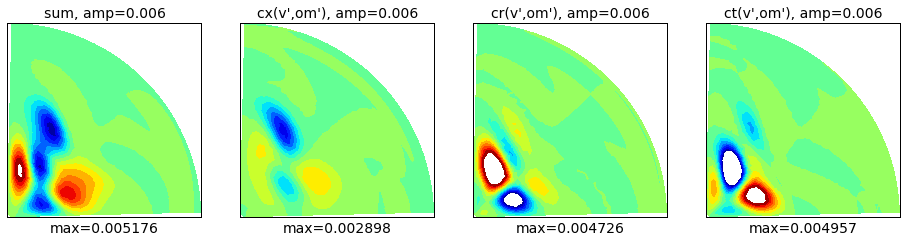

In [32]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c11[1:-1,1:-1,42:43].mean(-1), (-0.006,0.006))
plt.title("sum, amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c11[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,2)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c1[1:-1,1:-1,42:43].mean(-1), (-0.006, 0.006))
plt.title("cx(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c1[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,3)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c2[1:-1,1:-1,42:43].mean(-1), (-0.006,0.006))
plt.title("cr(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c2[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

plt.subplot(1,4,4)
pp.polar_contourf(r.f[1:-1], th.f[1:-1], c3[1:-1,1:-1,42:43].mean(-1), (-0.006,0.006))
plt.title("ct(v',om'), amp=0.006", fontsize=14)
plt.xlabel("max=%f" % c3[2:-2,2:-2,1:-1].mean(-1).max(), fontsize=14)

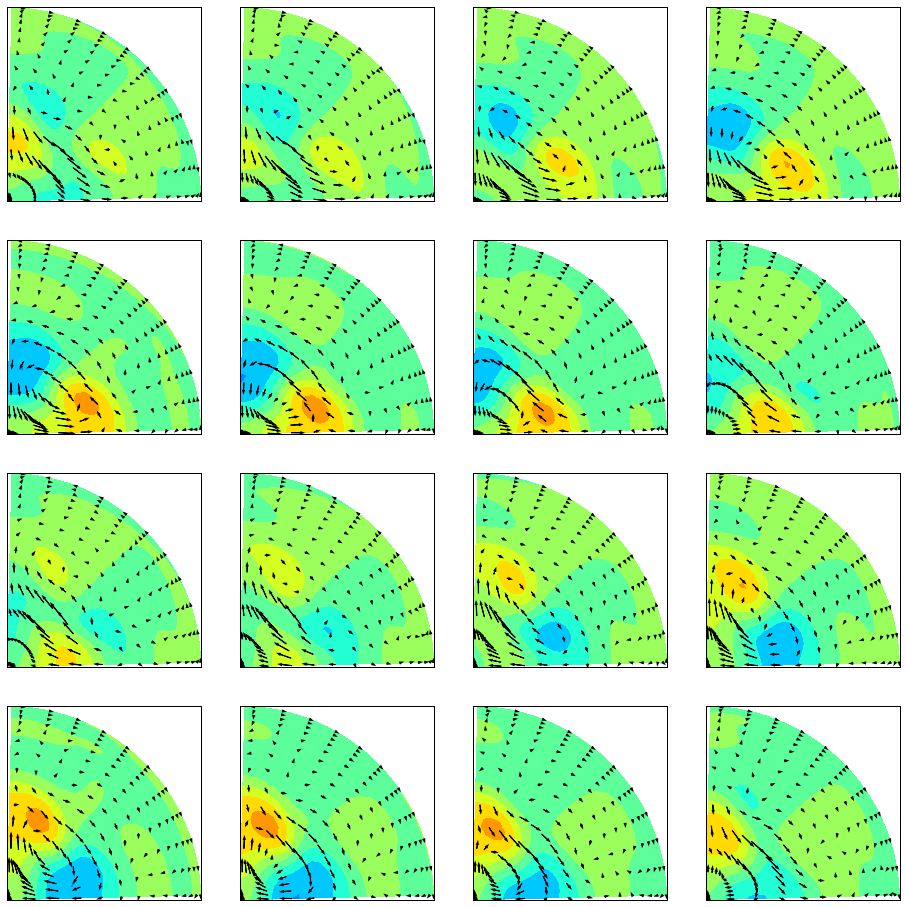

In [50]:
plt.figure(figsize=(16,16))

n = 1
for i in range(1,64,4):
    plt.subplot(4,4,n)
    n += 1
    pp.polar_arrow(vel1[1][1:-1:3,1:-1:3,i], vel1[2][1:-1:3,1:-1:3,i], r.f[1:-1:3], th.f[1:-1:3], 5)
    pp.polar_contourf(r.f[1:-1], th.f[1:-1], vel1[0][1:-1,1:-1,i]  , (-0.1,0.1))
